In [1]:
import re
import pandas as pd 
import numpy as np
import seaborn as sns
from nltk.stem import PorterStemmer
from scipy.stats import linregress

import matplotlib.pyplot as plt

In [2]:
def get_new_word_count_df(
    df, 
    remove_words=( 
    #include all common used English words, e.g., "the","of","off","and","to","a","an","in","into","for","is","was",
    ),
    time_scaler=100
):
    ps =PorterStemmer()
    #find in the cvs file the column named "transcript" (the column we analyze new words probability), and discard other columns
    script_data = df[~pd.isnull(df["transcript"])].copy()
    
    #replace the following char with space
    script_data["processed_transcript"] = script_data["transcript"].str.lower().str.replace(
        "…|\.|,|[0-9]|\?|\([^\(]*\)|\!|\'|\’|\"", 
        " "
    )
    #sort data by time
    script_data.sort_values("start_time", inplace=True)

    #set variables for counting new words for each row (time stamped).
    set_inc = set()
    cumulative_counts = []
    new_word_counts = []
    new_words = []
    raw_word_counts = []
    for _, row in script_data.iterrows():
        row_words = [w for w in re.split(" +", row["processed_transcript"]) if w != ""]
        raw_word_counts.append(len(row_words))
        #1. exclude words in remove_words; 2. get unique words in each row; 
        #3. And for each unique word, stem words; 4 get unique words.
        row_set = {ps.stem(w) for w in str_2_set(row["processed_transcript"]) if w not in remove_words}
        
        #identify and keep track of new words
        new_word_count = 0
        _new_words = []
        for w in row_set:
            if w not in set_inc:
                new_word_count += 1
                _new_words.append(w)
        new_word_counts.append(new_word_count)
        cumulative_counts.append(sum(new_word_counts))
        new_words.append(_new_words)
        set_inc.update(row_set)
    
    #set up new columns for the following
    script_data["raw_word_count"] = raw_word_counts
    script_data["new_word_count"] = new_word_counts
    script_data["cumulative_word_count"] = cumulative_counts
    script_data["new_words"] = new_words

    #change time format to make plotting easier
    script_data["tnstart_datetime"] = pd.to_datetime(script_data["start_time"]).dt.time
    script_data["tnend_datetime"] = pd.to_datetime(script_data["end_time"]).dt.time

    #create a column for percentage of new words (+1 to avoid dividing by 0)
    script_data["new_word_pct"] = (script_data["new_word_count"] + 1)/ (script_data["cumulative_word_count"].max() + 1)
    
    #log transformation
    script_data["new_word_log"] = script_data["new_word_pct"].apply(pd.np.log)
    
    #transform time (h:m:s) to integer 
    start_time = pd.to_datetime(script_data["start_time"]).astype(int)
    end_time = pd.to_datetime(script_data["end_time"]).astype(int)
    
    #start from beginning time
    script_data["tnstart_from_start"] = (start_time - start_time.min()) / 1000000000.0
    #(optional) set an index to track the minutes
    script_data["minute_index"] = (((start_time - start_time.min()) +(end_time - start_time.min())) /1000000000.0/120).astype(int)

    #set a time_weight variable for deweighing the new words percentage at the beginning time
    script_data["time_weight"] = 1 - (-time_scaler * script_data["tnstart_from_start"]).apply(np.exp)   

    script_data["time_weighted_new_word_count"] = script_data["new_word_count"] * script_data["time_weight"]
    script_data["time_weighted_new_word_count_rescaled"] = script_data["time_weighted_new_word_count"] / script_data["raw_word_count"]

    
    return script_data

def str_2_set(a):
    return set(re.split(" +", a))

#plots
def make_plots(df):
    sns.lineplot(data=df, x="tnstart_datetime", y="cumulative_word_count")
    plt.show() 
    sns.lineplot(data=df, x="tnstart_datetime", y="new_word_count")
    plt.show() 
    sns.lineplot(data=df, x="tnstart_datetime", y="time_weighted_new_word_count")
    plt.show()
    sns.lineplot(data=df, x="tnstart_datetime", y="new_word_pct")
    plt.show()
    # sns.lineplot(data=df, x="tnstart_datetime", y="new_word_log")
    # plt.show()
    sns.lineplot(data=df, x="tnstart_datetime", y="time_weight")
    plt.show()

In [3]:
input_csv = "inputfile.csv"
output_folder = "output_folder"

In [4]:
data = pd.read_csv(input_csv)

In [5]:
speakers = data.speaker.drop_duplicates()
speaker_1 = speakers.iloc[0]
speaker_2 = speakers.iloc[1]

#check if the speakers are correct
print(f"speaker 1: {speaker_1}, speaker 2: {speaker_2}")

speaker 1: WB, speaker 2: NM


In [6]:
#do the "new word count" at three levels: speaker 1, speaker 2 and at the group level:
speaker1_df = get_new_word_count_df(data[data["speaker"] == speaker_1], time_scaler=0.01)
speaker2_df = get_new_word_count_df(data[data["speaker"] == speaker_2],time_scaler=0.01)
dyad_df = get_new_word_count_df(data,time_scaler=0.01)

In [8]:
#check output for speaker_1
speaker1_df.head(50) 

,start_time,end_time,speaker,transcript,social_interaction,interval,interval_id_old,interval_id,tstart,tend,...,new_words,tnstart_datetime,tnend_datetime,new_word_pct,new_word_log,tnstart_from_start,minute_index,time_weight,time_weighted_new_word_count,time_weighted_new_word_count_rescaled
0,10:14:29.833000000,10:14:32.581000000,WB,Let me just read these through and then we can...,0,"[0 days 10:14:29, 0 days 10:18:24)",0,0,10:14:29,10:18:24,...,"[me, read, let, we, chat, just, through, and, ...",10:14:29.833000,10:14:32.581000,0.009324,-4.675163,0.000,0,0.000000,0.000000,0.000000
1,10:14:37.164000000,10:14:38.222000000,WB,there are a bunch of papers here,0,"[0 days 10:14:29, 0 days 10:18:24)",0,0,10:14:29,10:18:24,...,"[a, are, here, paper, there, of, bunch]",10:14:37.164000,10:14:38.222000,0.006216,-5.080628,7.331,0,0.070687,0.494811,0.070687
6,10:16:07.359000000,10:16:07.989000000,WB,(sign),0,"[0 days 10:14:29, 0 days 10:18:24)",0,0,10:14:29,10:18:24,...,[],10:16:07.359000,10:16:07.989000,0.001554,-6.466922,97.526,1,0.622906,0.622906,inf
7,10:16:51.236000000,10:16:57.532000000,WB,"oh man, most joyful time with my children is w...",0,"[0 days 10:14:29, 0 days 10:18:24)",0,0,10:14:29,10:18:24,...,"[i, off, children, is, time, with, when, most,...",10:16:51.236000,10:16:57.532000,0.015540,-4.164337,141.403,2,0.756839,14.379934,0.653633
9,10:17:01.211000000,10:17:06.199000000,WB,most joyful time with my kids is when I hit a ...,0,"[0 days 10:14:29, 0 days 10:18:24)",0,0,10:14:29,10:18:24,...,"[work, kid, not, about, think]",10:17:01.211000,10:17:06.199000,0.004662,-5.368310,151.378,2,0.779923,3.899617,0.155985
12,10:17:06.878000000,10:17:11.897000000,WB,That's gonna handle with children... lifestyle...,0,"[0 days 10:14:29, 0 days 10:18:24)",0,0,10:14:29,10:18:24,...,"[lifestyl, s, gonna, that, everyth, handl]",10:17:06.878000,10:17:11.897000,0.005439,-5.214159,157.045,2,0.792048,4.752291,0.528032
14,10:17:17.278000000,10:17:19.432000000,WB,"um, you are not married, right?",0,"[0 days 10:14:29, 0 days 10:18:24)",0,0,10:14:29,10:18:24,...,"[right, marri, um, you]",10:17:17.278000,10:17:19.432000,0.003885,-5.550631,167.445,2,0.812589,3.250355,0.541726
16,10:17:19.926000000,10:17:20.374000000,WB,don't have kids?,0,"[0 days 10:14:29, 0 days 10:18:24)",0,0,10:14:29,10:18:24,...,"[don, have, t]",10:17:19.926000,10:17:20.374000,0.003108,-5.773775,170.093,2,0.817486,2.452459,0.613115
18,10:17:20.938000000,10:17:25.522000000,WB,"have you ever played with kids? you know, that...",0,"[0 days 10:14:29, 0 days 10:18:24)",0,0,10:14:29,10:18:24,...,"[know, ever, kind, play, thing]",10:17:20.938000,10:17:25.522000,0.004662,-5.368310,171.105,2,0.819324,4.096620,0.292616
21,10:17:26.257000000,10:17:26.538000000,WB,cool,0,"[0 days 10:14:29, 0 days 10:18:24)",0,0,10:14:29,10:18:24,...,[cool],10:17:26.257000,10:17:26.538000,0.001554,-6.466922,176.424,2,0.828683,0.828683,0.828683


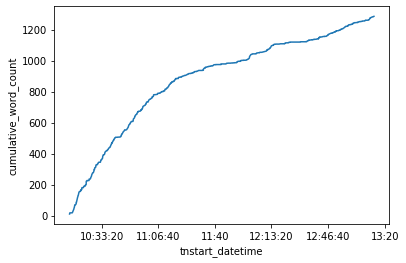

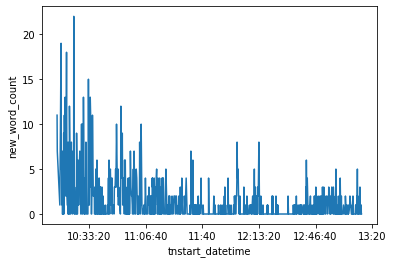

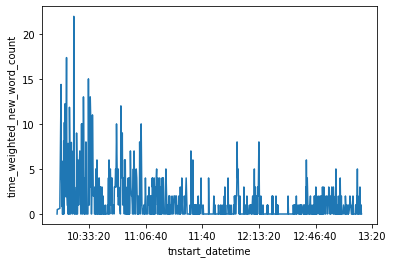

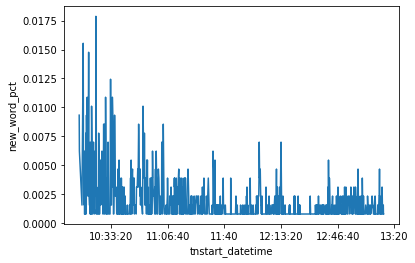

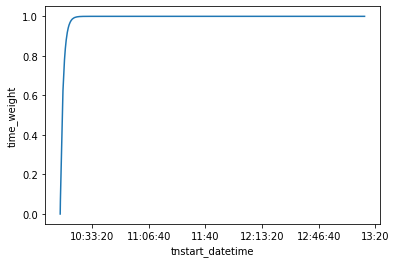

In [9]:
#Plots for speaker 1
make_plots(speaker1_df)

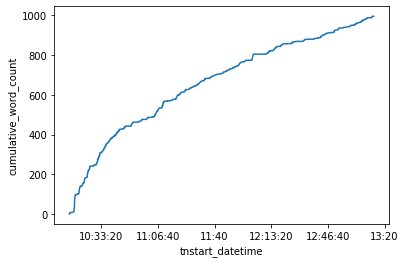

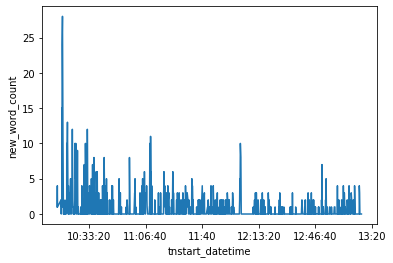

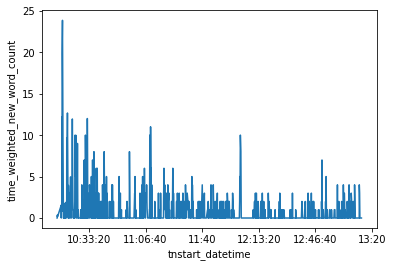

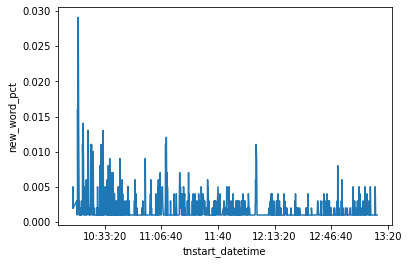

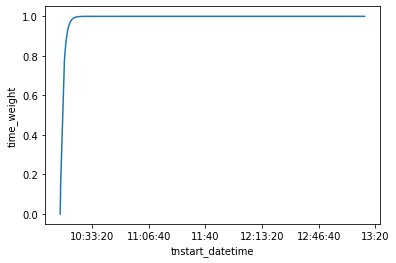

In [11]:
#Plots for speaker 2
make_plots(speaker2_df)

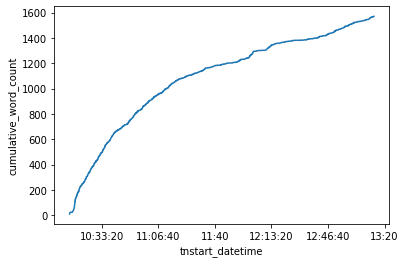

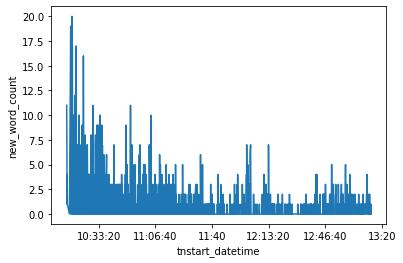

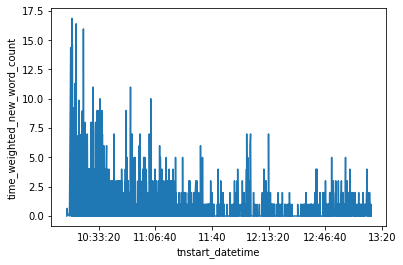

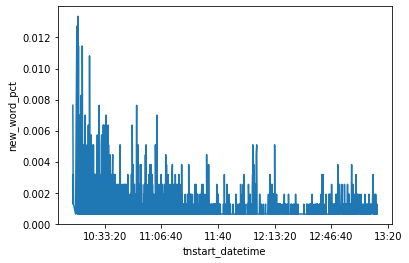

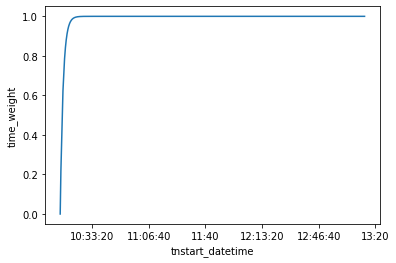

In [15]:
#Plot for dyad level data
make_plots(dyad_df)

In [16]:
#save the outputs
speaker1_csv = output_folder + f"{speaker_1}_new_word_try.csv"
speaker1_df.to_csv(speaker1_csv, index=False)
print(f"csv saved to: {speaker1_csv}")

csv saved to: Pitch_Mean_statement/clean_csv/all_dyads/mar2021/dyad3/WB_new_word_try.csv


In [17]:
speaker2_csv = output_folder + f"{speaker_2}_new_word_try.csv"
speaker2_df.to_csv(speaker2_csv, index=False)
print(f"csv saved to: {speaker2_csv}")

csv saved to: Pitch_Mean_statement/clean_csv/all_dyads/mar2021/dyad3/NM_new_word_try.csv


In [18]:
dyad_csv = output_folder + "dyad_new_word_try.csv"
dyad_df.to_csv(dyad_csv, index=False)
print(f"csv saved to: {dyad_csv}")

csv saved to: Pitch_Mean_statement/clean_csv/all_dyads/mar2021/dyad3/dyad_new_word_try.csv


In [1470]:
ps =PorterStemmer()

In [1471]:
ps.stem("nondenominational")

'nondenomin'